In [1]:
import fedhex as fx
from fedhex.pretrain import generation as fxgen
from fedhex.train import SelectiveProgbarLogger
from matplotlib import pyplot as plt
import numpy as np

Welcome to JupyROOT 6.30/02


2024-04-17 13:18:54.269344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ndim = 2
nx = ny = 10
sigmax = 1 / (nx + 1) / 2
sigmay = 1 / (ny + 1) / 2
sigma = np.array([sigmax, sigmay])

gen = fx.GridGaussGenerator(cov_strat=fxgen.RepeatStrategy(fxgen.DiagCov(ndim=ndim, sigma=sigma)),
                      ngausx=nx,
                      ngausy=ny,
                      seed=0x2024)

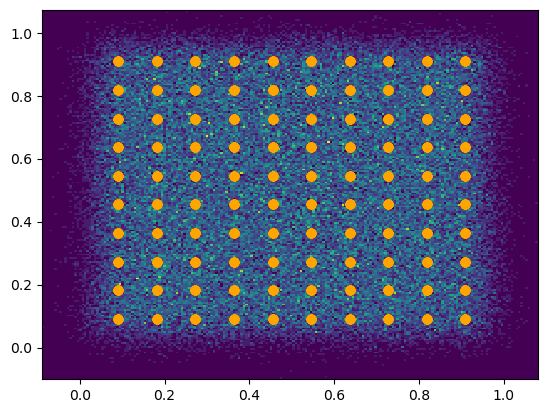

In [6]:
nsamp = 1000
samp, lab = gen.generate(nsamp=nsamp)
lablocs = np.unique(lab, axis=0)
plt.hist2d(samp[:,0], samp[:,1], bins=(200,200))
plt.scatter(lab[:,0], lab[:,1], c="orange")
pass

In [7]:
nmade = 10
ninputs = ncinputs = ndim
hidden_layers = [128, 128]
batch_size = 1024
end_epoch = 200

callbacks = []
log_freq = 10
callbacks.append(SelectiveProgbarLogger(1, epoch_interval=log_freq, epoch_end=end_epoch))
flow_path = "model/2024.04.17-gg"

model = fx.MADEManager(nmade=nmade,
               ninputs=ninputs,
               ncinputs=ncinputs,
               hidden_layers=hidden_layers,
               activation="relu")
model.compile_model()
model.train_model(dm=gen,
                  batch_size=batch_size,
                  end_epoch=end_epoch,
                  callbacks=callbacks,
                  path=flow_path)

13:20:12.17 <I> [Training begins]
epoch begin: 2024-04-17 13:20:52.650581 | time elapsed: 0:00:40.417628
Epoch 10/200
98/98 [==============================] - 3s 35ms/sample - loss: -0.6643
epoch begin: 2024-04-17 13:21:30.904065 | time elapsed: 0:01:18.671112
Epoch 20/200
98/98 [==============================] - 4s 46ms/sample - loss: -0.6761
epoch begin: 2024-04-17 13:22:14.655548 | time elapsed: 0:02:02.422595
Epoch 30/200
98/98 [==============================] - 4s 41ms/sample - loss: -0.6787
epoch begin: 2024-04-17 13:22:57.459629 | time elapsed: 0:02:45.226676
Epoch 40/200
98/98 [==============================] - 4s 45ms/sample - loss: -0.6811
epoch begin: 2024-04-17 13:23:41.606029 | time elapsed: 0:03:29.373076
Epoch 50/200
98/98 [==============================] - 4s 45ms/sample - loss: -0.6823
epoch begin: 2024-04-17 13:24:31.583043 | time elapsed: 0:04:19.350090
Epoch 60/200
98/98 [==============================] - 5s 55ms/sample - loss: -0.6798
epoch begin: 2024-04-17 13:25:

INFO:tensorflow:Assets written to: model/2024.04.17-gg/assets


13:35:22.31 <I> [Training ends]
0:15:10.14 <I> [Time elapsed]


/home/asatk/miniconda3/envs/rootflows/lib/python3.11/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(
/home/asatk/miniconda3/envs/rootflows/lib/python3.11/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
ngen = 10000
nlabs = 10
# newlab = np.repeat([[0.135, 0.135]], ngen, axis=0)
newlablocs = np.random.uniform(0.0, 1.0, nlabs * ncinputs).reshape(nlabs, ncinputs)
newlab = np.repeat(newlablocs, ngen, axis=0)
newsamp = model.eval_model(newlab, gen)

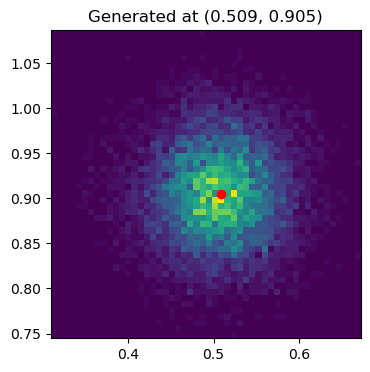

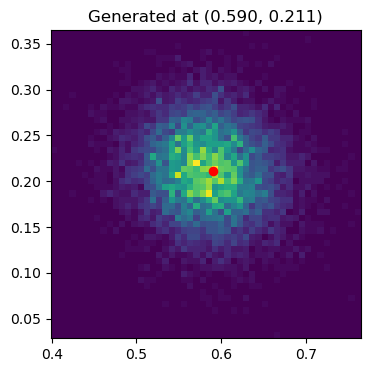

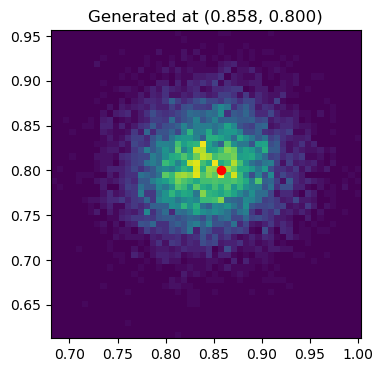

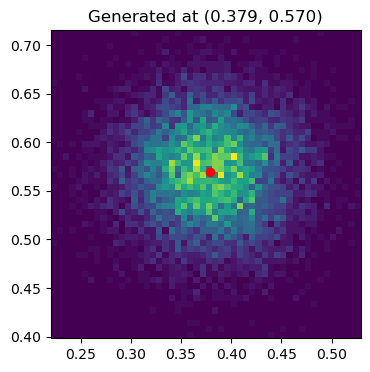

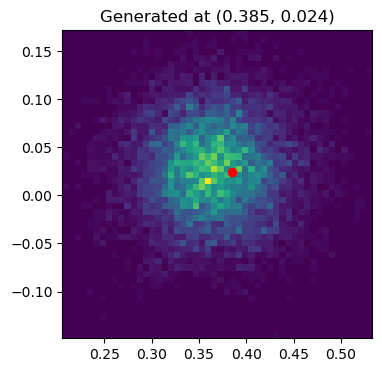

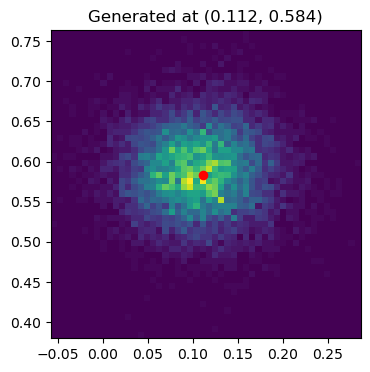

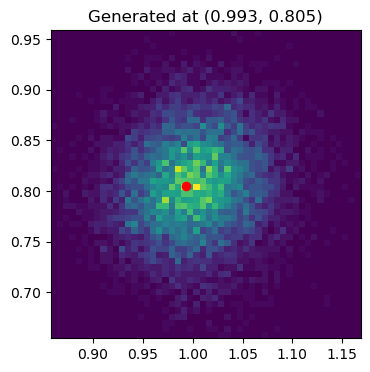

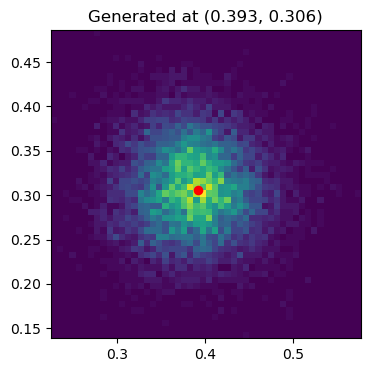

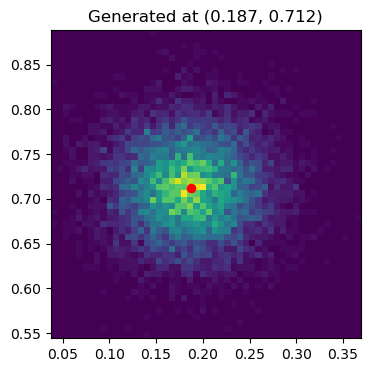

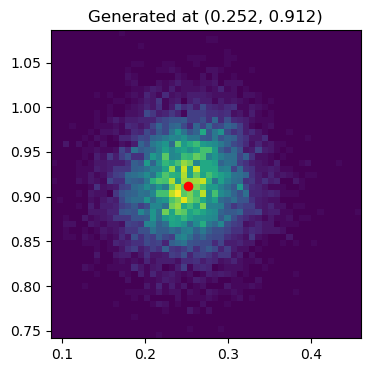

In [19]:
for i in range(nlabs):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    ax: plt.Axes
    lbl = newlablocs[i]
    pts = newsamp[i * ngen: (i+1)*ngen]
    ax.hist2d(pts[:,0], pts[:,1], bins=(50,50))
    ax.scatter(lbl[0], lbl[1], c="red", s=35)
    ax.set_title(f"Generated at ({lbl[0]:.3f}, {lbl[1]:.3f})")

In [59]:
1 / (nx + 1) / np.sqrt(2)

0.06428243465332249

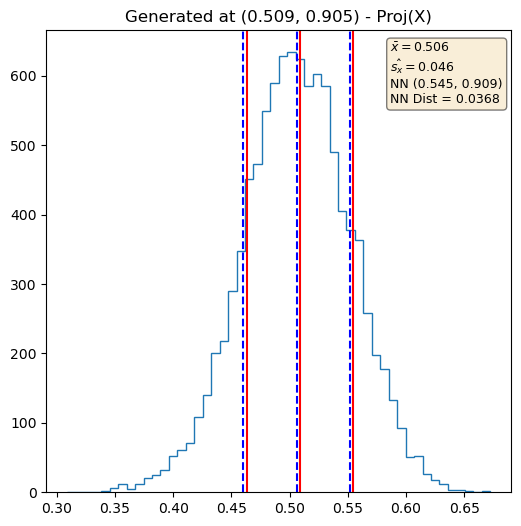

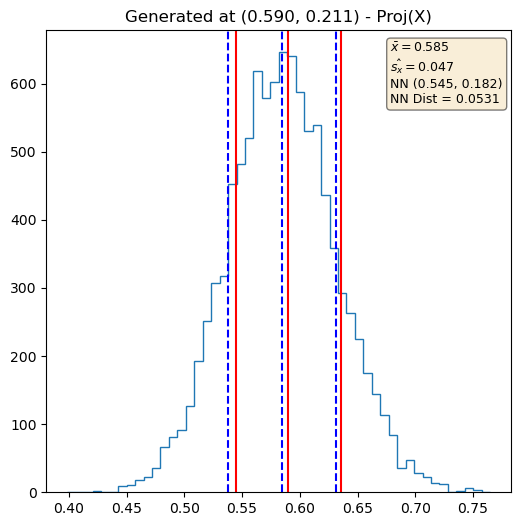

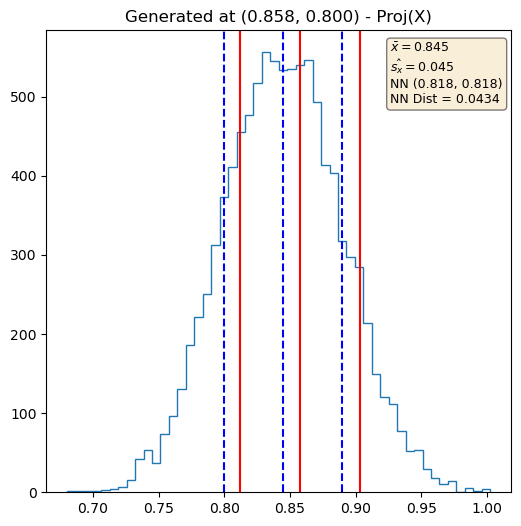

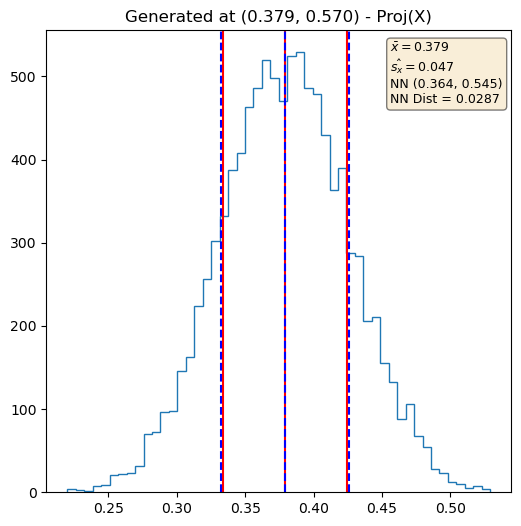

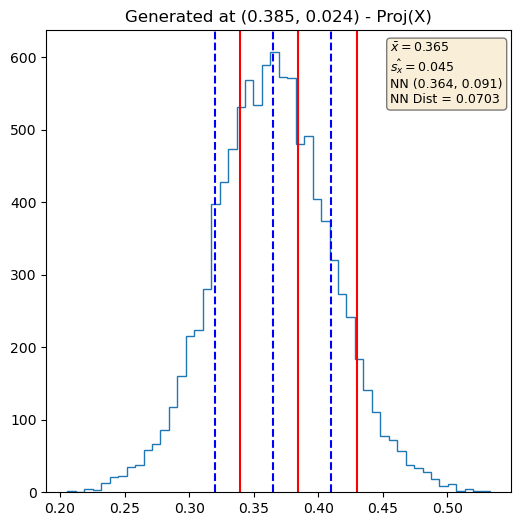

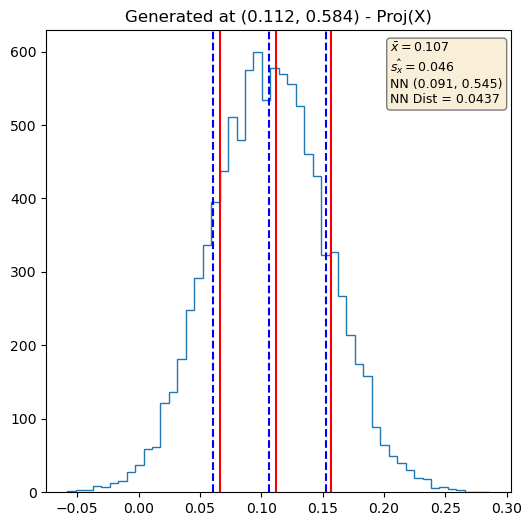

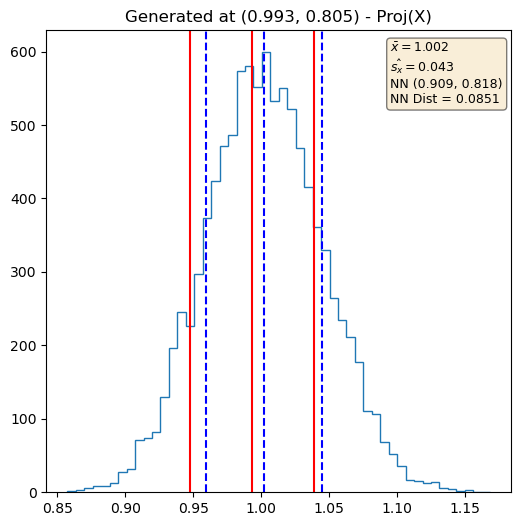

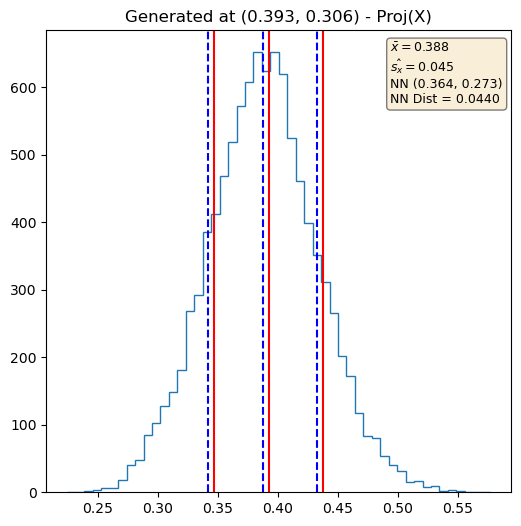

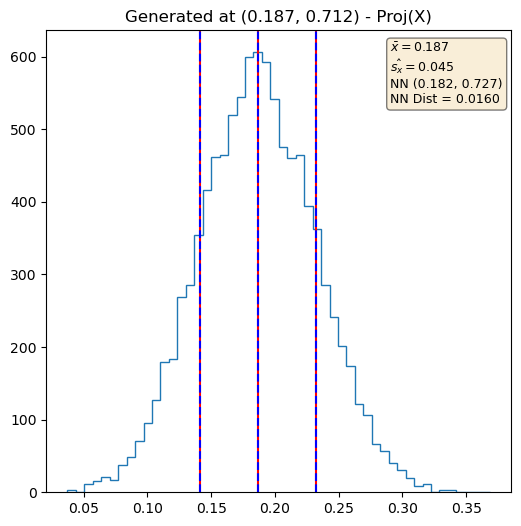

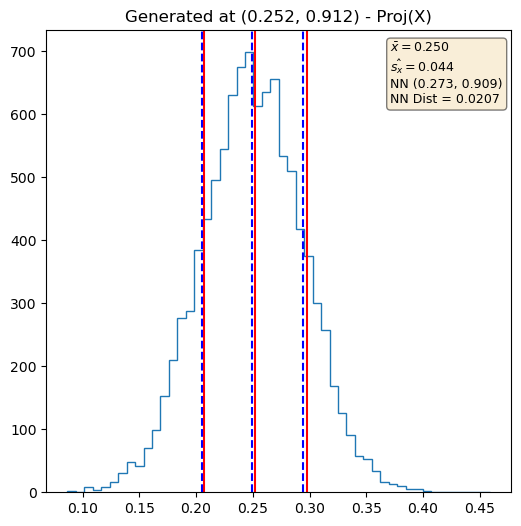

In [73]:
bbox = dict(
    boxstyle="round",
    facecolor="wheat",
    alpha=0.5
)
for i in range(nlabs):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax: plt.Axes

    lbl = newlablocs[i]
    pts = newsamp[i * ngen: (i+1)*ngen]

    mean = np.mean(pts[:,0])
    std = np.std(pts[:,0])

    l2norm = np.sqrt(np.sum(np.square(lbl - lablocs), axis=1))
    nearest_idx = np.argmin(l2norm)
    nearest_dist = l2norm[nearest_idx]
    nearest_lbl = lablocs[nearest_idx]
    s = rf"$\bar{{x}} = {mean:.03f}$" + "\n" + rf"$\hat{{s_x}} = {std:.03f}$" + "\n" + \
        f"NN ({nearest_lbl[0]:.3f}, {nearest_lbl[1]:.3f})\n" + \
        f"NN Dist = {nearest_dist:.4f}"

    ax.hist(pts[:,0], bins=50, histtype="step")
    ax.axvline(lbl[0], c="red")
    ax.axvline(lbl[0] - sigma[0], c="red")
    ax.axvline(lbl[0] + sigma[0], c="red")

    ax.axvline(mean, c="blue", linestyle="dashed")
    ax.axvline(mean - std, c="blue", linestyle="dashed")
    ax.axvline(mean + std, c="blue", linestyle="dashed")
    ax.set_title(f"Generated at ({lbl[0]:.3f}, {lbl[1]:.3f}) - Proj(X)")
    
    ax.text(0.74, 0.975, s, transform=ax.transAxes, fontsize=9, verticalalignment="top", bbox=bbox)

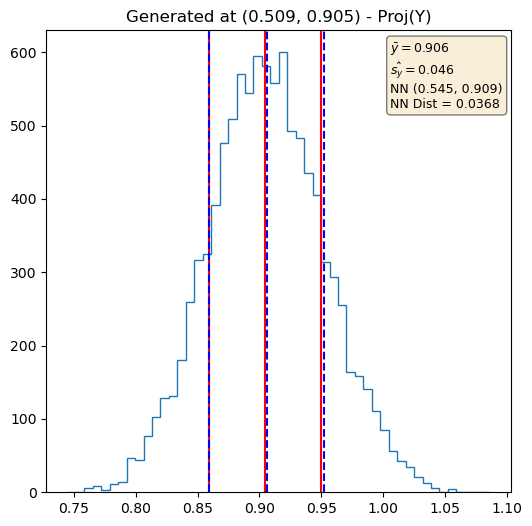

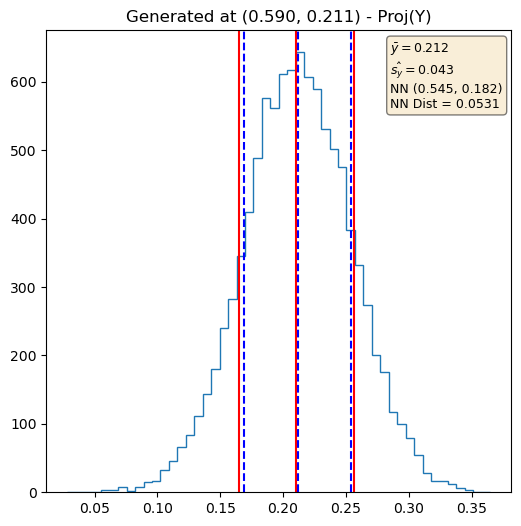

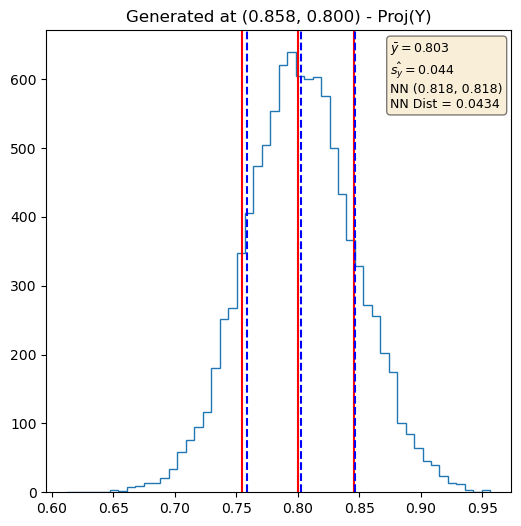

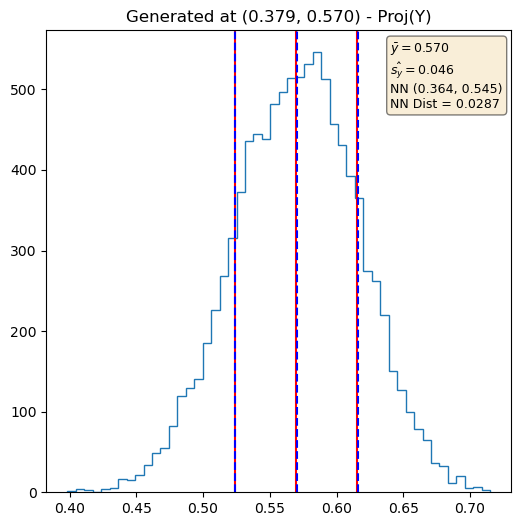

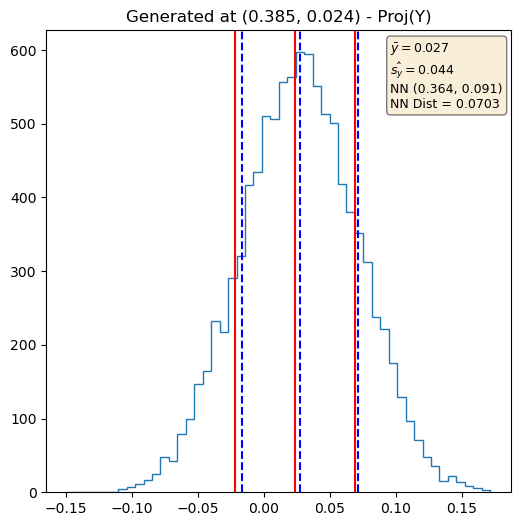

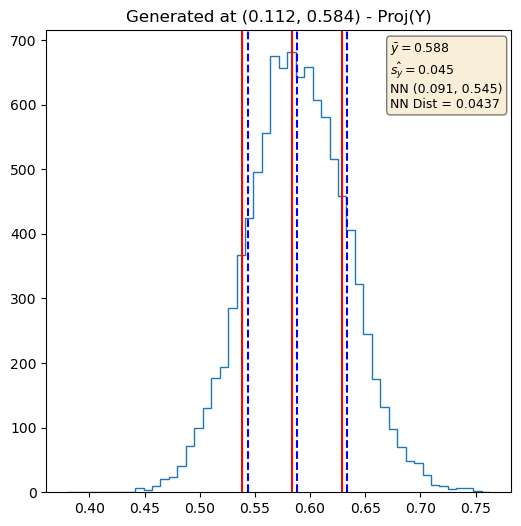

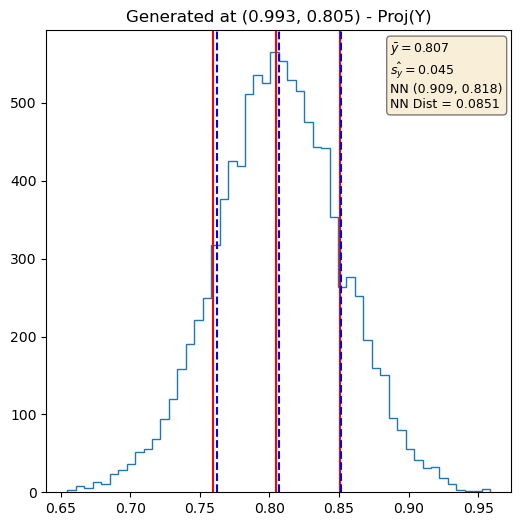

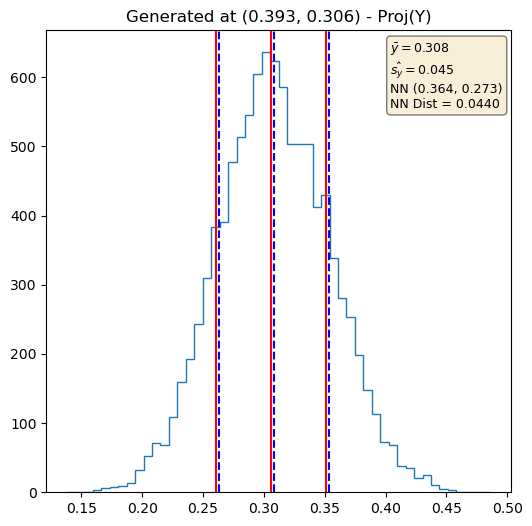

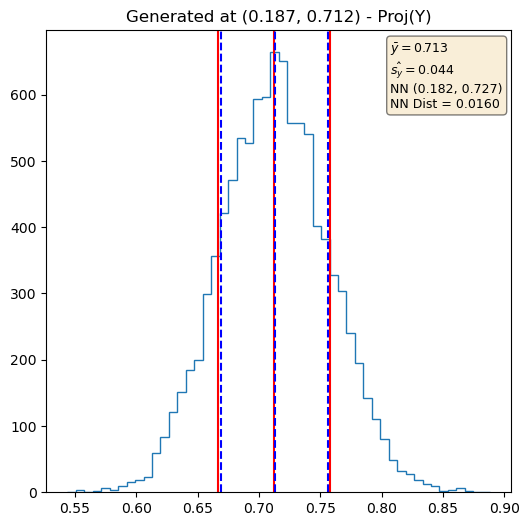

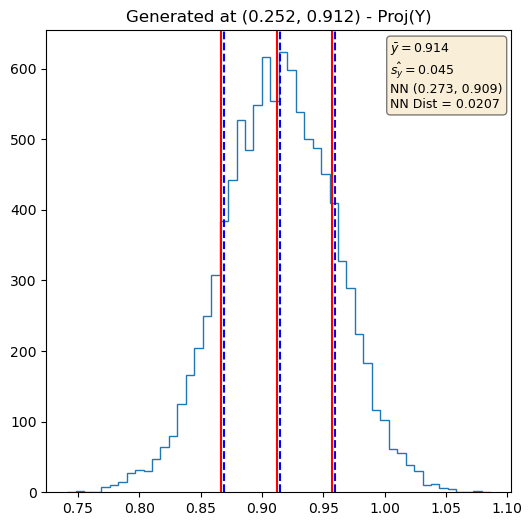

In [72]:
for i in range(nlabs):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax: plt.Axes
    lbl = newlablocs[i]
    pts = newsamp[i * ngen: (i+1)*ngen]

    mean = np.mean(pts[:,1])
    std = np.std(pts[:,1])

    l2norm = np.sqrt(np.sum(np.square(lbl - lablocs), axis=1))
    nearest_idx = np.argmin(l2norm)
    nearest_dist = l2norm[nearest_idx]
    nearest_lbl = lablocs[nearest_idx]
    s = rf"$\bar{{y}} = {mean:.03f}$" + "\n" + rf"$\hat{{s_y}} = {std:.03f}$" + "\n" + \
        f"NN ({nearest_lbl[0]:.3f}, {nearest_lbl[1]:.3f})\n" + \
        f"NN Dist = {nearest_dist:.4f}"

    ax.hist(pts[:,1], bins=50, histtype="step")
    ax.axvline(lbl[1], c="red")
    ax.axvline(lbl[1] - sigma[1], c="red")
    ax.axvline(lbl[1] + sigma[1], c="red")    

    ax.axvline(mean, c="blue", linestyle="dashed")
    ax.axvline(mean - std, c="blue", linestyle="dashed")
    ax.axvline(mean + std, c="blue", linestyle="dashed")
    ax.set_title(f"Generated at ({lbl[0]:.3f}, {lbl[1]:.3f}) - Proj(Y)")

    ax.text(0.74, 0.975, s, transform=ax.transAxes, fontsize=9, verticalalignment="top", bbox=bbox)

In [80]:
from scipy.stats import kstest
from scipy.stats import norm

In [83]:
true_cov = [[sigmax, 0], [0, sigmay]]
means = []
nn_dists = []
for i in range(nlabs):
    lbl = newlablocs[i]
    pts = newsamp[i * ngen: (i+1)*ngen]

    mean = np.mean(pts, axis=0)

    means.append(mean)

    l2norm = np.sqrt(np.sum(np.square(lbl - lablocs), axis=1))
    nearest_dist = np.min(l2norm)

    nn_dists.append(nearest_dist)

    # theory = np.random.normal(mean, np.array(true_cov), ngen)


    # resx = kstest(pts[:, 0], theory[:, 0])
    resx = kstest(pts[:, 0], norm.cdf)
    resy = kstest(pts[:, 1], norm.cdf)
    print(resx)
    print(resy)


KstestResult(statistic=0.6431832651132526, pvalue=0.0, statistic_location=0.3895985, statistic_sign=-1)
KstestResult(statistic=0.7816885887640537, pvalue=0.0, statistic_location=0.7918934, statistic_sign=-1)
KstestResult(statistic=0.6751477048074688, pvalue=0.0, statistic_location=0.47175092, statistic_sign=-1)
KstestResult(statistic=0.5354905825877803, pvalue=0.0, statistic_location=0.099654235, statistic_sign=-1)
KstestResult(statistic=0.7644817021753141, pvalue=0.0, statistic_location=0.72763574, statistic_sign=-1)
KstestResult(statistic=0.7497600724467324, pvalue=0.0, statistic_location=0.69241005, statistic_sign=-1)
KstestResult(statistic=0.5974578001825145, pvalue=0.0, statistic_location=0.26775956, statistic_sign=-1)
KstestResult(statistic=0.6687522793323083, pvalue=0.0, statistic_location=0.45057562, statistic_sign=-1)
KstestResult(statistic=0.5931048762161477, pvalue=0.0, statistic_location=0.25051352, statistic_sign=-1)
KstestResult(statistic=0.4630385904894123, pvalue=0.0, s